# Fraud Detection in Python

- 분석 목표 : fraudulent behavior 부정의심거래 탐지 모델 구현 및 Imbalanced Classification
1. Supervised Learning 지도학습으로 부정의심거래 탐지
1. Unsupervised Learning 비지도학습으로 새로운 유형의 부정의심거래 발견
1. 불균형 데이터 분류 문제 핸들링

- Fraud detection 활용 분야: Insurance / Credit card / Identity theft / Money laundering / Tax evasion / Healthcare / Product warranty / e-commerce


- Fraud detection Challenges
    - **데이터 불균형이 심함** ; < 0.01% of transactions 
    - 부정의심거래와 이를 감추기위한 시도들의 유형이 발전, 다양하며 네트워크 침입 같은 조직적인 범죄의 형태


- Fraud analytics teams 부정거래탐지 분석 업무
    - 주로 규칙 기반 시스템을 사용 (이전 데이터 기반으로 thresholds를 세팅)
    - 뉴스
    - external lists of fraudulent accounts and names
        - suspicious names or track an external hit list from police to reference check against the client base
        
    - **Sometimes** use machine learning algorithms to detect fraud or suspicious behavior
        - Existing sources can be used as inputs into the ML model
        - Verify the veracity of rules based labels

## module

In [8]:
# Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Data Mining
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path # file directory
import seaborn as sns
from itertools import product
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora

# pandas configuration Options
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

## load datasets

In [14]:
data=Path.cwd() / 'data'

In [18]:
ch1 = data / 'chapter_1'
cc1_file = ch1 / 'creditcard_sampledata.csv'
cc3_file = ch1 / 'creditcard_sampledata_3.csv'

# using labeled data
ch2 = data / 'chapter_2'
cc2_file = ch2 / 'creditcard_sampledata_2.csv'

# using unlabeled data
ch3 = data / 'chapter_3'
banksim_file = ch3 / 'banksim.csv'
banksim_adj_file = ch3 / 'banksim_adj.csv'
db_full_file = ch3 / 'db_full.pickle'
labels_file = ch3 / 'labels.pickle'
labels_full_file = ch3 / 'labels_full.pickle'
x_scaled_file = ch3 / 'x_scaled.pickle'
x_scaled_full_file = ch3 / 'x_scaled_full.pickle'

# using text
ch4 = data / 'chapter_4'
enron_emails_clean_file = ch4 / 'enron_emails_clean.csv'
cleantext_file = ch4 / 'cleantext.pickle'
corpus_file = ch4 / 'corpus.pickle'
dict_file = ch4 / 'dict.pickle'
ldamodel_file = ch4 / 'ldamodel.pickle'

In [19]:
df = pd.read_csv(cc3_file)

## EDA

### 1. Imbalanced data

In [22]:
df.shape

(5050, 31)

In [20]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,258647,1.725265,-1.337256,-1.012687,-0.361656,-1.431611,-1.098681,-0.842274,-0.026594,-0.032409,0.215113,1.618952,-0.654046,-1.442665,-1.546538,-0.230008,1.785539,1.419793,0.071666,0.233031,0.275911,0.414524,0.793434,0.028887,0.419421,-0.367529,-0.155634,-0.015768,0.010790,189.00,0
1,69263,0.683254,-1.681875,0.533349,-0.326064,-1.455603,0.101832,-0.520590,0.114036,-0.601760,0.444011,1.521570,0.499202,-0.127849,-0.237253,-0.752351,0.667190,0.724785,-1.736615,0.702088,0.638186,0.116898,-0.304605,-0.125547,0.244848,0.069163,-0.460712,-0.017068,0.063542,315.17,0
2,96552,1.067973,-0.656667,1.029738,0.253899,-1.172715,0.073232,-0.745771,0.249803,1.383057,-0.483771,-0.782780,0.005242,-1.273288,-0.269260,0.091287,-0.347973,0.495328,-0.925949,0.099138,-0.083859,-0.189315,-0.426743,0.079539,0.129692,0.002778,0.970498,-0.035056,0.017313,59.98,0
3,281898,0.119513,0.729275,-1.678879,-1.551408,3.128914,3.210632,0.356276,0.920374,-0.160589,-0.801748,0.137341,-0.156740,-0.429388,-0.752392,0.155272,0.215068,0.352222,-0.376168,-0.398920,0.043715,-0.335825,-0.906171,0.108350,0.593062,-0.424303,0.164201,0.245881,0.071029,0.89,0
4,86917,1.271253,0.275694,0.159568,1.003096,-0.128535,-0.608730,0.088777,-0.145336,0.156047,0.022707,-0.963306,-0.228074,-0.324933,0.390609,1.065923,0.285930,-0.627072,0.170175,-0.215912,-0.147394,0.031958,0.123503,-0.174528,-0.147535,0.735909,-0.262270,0.015577,0.015955,6.53,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5050 non-null   int64  
 1   V1          5050 non-null   float64
 2   V2          5050 non-null   float64
 3   V3          5050 non-null   float64
 4   V4          5050 non-null   float64
 5   V5          5050 non-null   float64
 6   V6          5050 non-null   float64
 7   V7          5050 non-null   float64
 8   V8          5050 non-null   float64
 9   V9          5050 non-null   float64
 10  V10         5050 non-null   float64
 11  V11         5050 non-null   float64
 12  V12         5050 non-null   float64
 13  V13         5050 non-null   float64
 14  V14         5050 non-null   float64
 15  V15         5050 non-null   float64
 16  V16         5050 non-null   float64
 17  V17         5050 non-null   float64
 18  V18         5050 non-null   float64
 19  V19         5050 non-null  

In [33]:
# label : class
df.Class.value_counts()/df.shape[0] * 100

0    99.009901
1     0.990099
Name: Class, dtype: float64

non-fraudulent cases : 99% 로 데이터 불균형 심함

In [74]:
# from dataframe to array
# https://www.marsja.se/how-to-convert-a-pandas-dataframe-to-a-numpy-array/
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    X = df.iloc[:, 1:29].values # data columns (V1 - V28)
    y = df.Class.values # lable column
    return X, y

# Scatter plot 
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r') #color
    plt.legend()
    return plt.show()

In [49]:
X,y = prep_data(df)
#print(df.head(1))
#print(X[0])

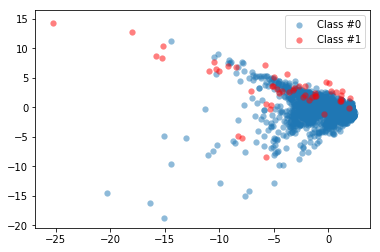

In [52]:
# V1, V2
plot_data(X,y)

In [71]:
X.shape

(5050, 28)

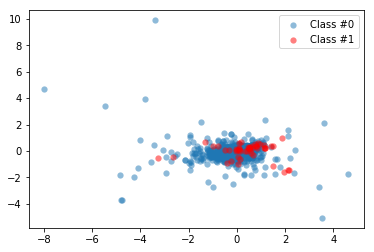

In [73]:
# V26, 27
plt.scatter(X[y == 0, 26 ], X[y == 0, 27], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(X[y == 1, 26 ], X[y == 1, 27], label="Class #1", alpha=0.5, linewidth=0.15, c='r') #color
plt.legend()
plt.show()

## 2. Data Resampling

SMOTE

In [79]:
X, y = prep_data(df)
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (5050, 28)
y shape: (5050,)


Before Sampling : 
 0    5000
1      50
dtype: int64

After Sampling : 
 0    5000
1    5000
dtype: int64


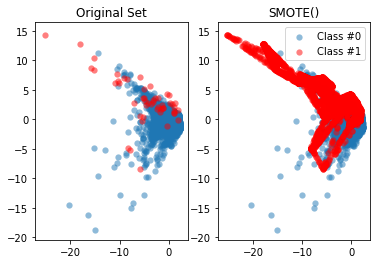

In [93]:
# resampling with SMOTE
method = SMOTE()
X_resampled, y_resampled = method.fit_resample(X,y)

print(f'Before Sampling : \n {pd.Series(y).value_counts()}\n')
print(f'After Sampling : \n {pd.Series(y_resampled).value_counts()}')

# plot
plt.subplot(1, 2, 1)
plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
plt.title('Original Set')

plt.subplot(1, 2, 2)
plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
plt.title(method)
plt.legend()
plt.show()